In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week3_model_free/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math 
import random 
from collections import defaultdict 
 

In [2]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        self._qvalues[state][action] = value


    def get_value(self, state):
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return 0.0
        value = max([self.get_qvalue(state,a) for a in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        gamma = self.discount
        learning_rate = self.alpha
        qvalue = (1-learning_rate)*self.get_qvalue(state,action) + learning_rate*(reward+gamma*self.get_value(next_state))
        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return None
        q_dict = {a: self.get_qvalue(state,a) for a in possible_actions}
    
        max_q = max(q_dict.values())
        best_actions = [action for action, q in q_dict.items() if q == max_q]
        best_action = random.choice(best_actions)

        return best_action

    def get_action(self, state):
        
        possible_actions = self.get_legal_actions(state)
        action = None
        if len(possible_actions) == 0:
            return None
        epsilon = self.epsilon
        if random.random() < self.epsilon:
            chosen_action = random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)

        return chosen_action

In [21]:
class EVSarsaAgent(QLearningAgent):


    def get_value(self, state):

        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

       
        if len(possible_actions) == 0:
            return 0.0

        
        best_action = self.get_best_action(state)
        state_value = (1-epsilon)*self.get_qvalue(state,best_action)

        num_action = len(possible_actions)
        for action in possible_actions:
            state_value += epsilon/num_action*self.get_qvalue(state,action)

        return state_value

In [15]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n


In [6]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [16]:
def play_and_train(env, agent, t_max=10**4):
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward


In [17]:
agent_sarsa = EVSarsaAgent(alpha = 0.25,epsilon=0.2,discount = 0.99,
                           get_legal_actions=lambda s: range(n_actions))
agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -29.05
QLearning mean reward = -92.47


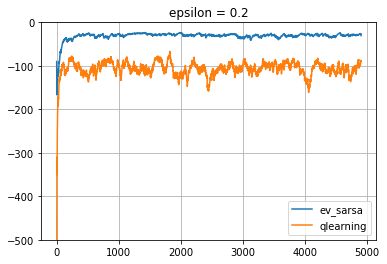

In [20]:
import pandas as pd
from IPython.display import clear_output 
def moving_average(x,span = 100):
  return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span = span).mean().values
rewards_sarsa, rewards_ql = [],[]
for i in range(5000):
  rewards_sarsa.append(play_and_train(env,agent_sarsa))
  rewards_ql.append(play_and_train(env,agent_ql))
  if i > 50000/5:
    agent_sarsa.epsilon *= 0.9
    agent_ql.epsilon *= 0.9
  if i % 100 == 0:
    clear_output(True)
    print("EVSARSA mean reward =", np.mean(rewards_sarsa[-100:]))
    print("QLearning mean reward =", np.mean(rewards_ql[-100:]))
    plt.title("epsilon = %s" %agent_ql.epsilon)
    plt.plot(moving_average(rewards_sarsa), label = 'ev_sarsa')
    plt.plot(moving_average(rewards_ql),label = 'qlearning')
    plt.grid()
    plt.legend()
    plt.ylim(-500,0)
    plt.show()
    



In [26]:
def draw_policy(env, agent):
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()              

In [27]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 v  v  >  v  >  >  v  >  v  >  >  v 
 >  >  >  >  >  v  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [28]:
class EVSoftmaxSarsaAgent(QLearningAgent):
  def get_value(self,state):
    epsilon = self.epsilon 
    possible_actions = self.get_legal_actions(state)
    if len(possible_actions) == 0:
      return 0.0
    Qvalues = np.array([self.get_qvalue(state,action) for action in possible_actions])
    exp_sum = sum(np.exp(Qvalues))
    probs = [np.exp(q)/exp_sum for q in Qvalues]
    state_value = 0
    for idx,action in enumerate(possible_actions):
      state_value += probs[idx]*Qvalues[idx]
    return state_value 
          


In [29]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

agent_softmax = EVSoftmaxSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))


EVSARSA mean reward = -32.18
QLEARNING mean reward = -122.7
SOFTMAX mean reward = -92.01


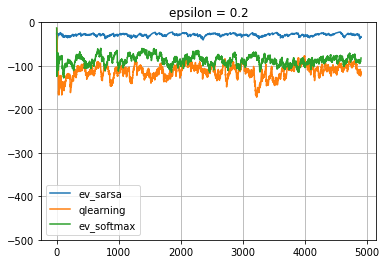

In [31]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa, rewards_ql = [], []
rewards_softmax = []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    rewards_softmax.append(play_and_train(env, agent_softmax))

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        print('SOFTMAX mean reward =', np.mean(rewards_softmax[-100:]))

        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.plot(moving_average(rewards_softmax), label='ev_softmax')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

In [32]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

print("Softmax-SARSA")
draw_policy(env, agent_softmax)

Q-Learning
 v  v  v  >  >  v  v  >  >  v  >  v 
 >  v  >  >  >  v  >  >  v  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
Softmax-SARSA
 >  >  >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
